# Plaidoirie ProPublica

## Introduction

Ce notebook vise à contrer la réponse de Northpointe à ProPublica, en réalisant une étude plus poussée. Notre argumentation se fera en 3 temps :
- La reprise des critères avancés par ProPublica, montrant un biais net contre les Afro-Américains. Nous démontrerons par ailleurs qu'un tel biais ne peut être expliqué par le grand nombre de jeunes dans la population Afro-Américaine
- La réalisation d'un algorithme satisfaisant à la fois les deux critères (predictive parity et equality of odds). Cela prouve que l'argument de Northpointe, consistant à opposer la Predictive Parity à l'Equality of odds, n'est pas recevable.
- Une réflexion éthique et juridique sur l'utilisation de ce type d'algorithmes dans le système judiciaire.

### Importation des données sur les détenus

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

import pandas as pd
from collections import Counter

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/EA MAP511/compas-scores-two-years.csv')

In [ ]:
dd = df[['sex', 'age', 'age_cat', 'race', 'decile_score', 'priors_count', 'score_text', 'c_charge_degree', 'two_year_recid', 'is_recid', 'days_b_screening_arrest',
        'juv_fel_count', 'juv_misd_count']].replace({
    'Greater than 45':'Above_FourtyFive',
    'Less than 25':'Below_TwentyFive',
    '25 - 45': 'Between_25_45',
    'M':'Misdemeanor',
    'F':'Felony'
})
dd = dd[(dd.days_b_screening_arrest <= 30) & (dd.days_b_screening_arrest >=-30)]\
        .drop(columns=['days_b_screening_arrest','is_recid'])\
        .assign(score_factor = lambda x: x['score_text'].map(lambda y: 1 if y!='Low' else 0))
dd = dd[(dd.race=='African-American') | (dd.race=='Caucasian')]
dd.head()

,sex,age,age_cat,race,decile_score,priors_count,score_text,c_charge_degree,two_year_recid,juv_fel_count,juv_misd_count,score_factor
1,Male,34,Between_25_45,African-American,3,0,Low,Felony,1,0,0,0
2,Male,24,Below_TwentyFive,African-American,4,4,Low,Felony,1,0,0,0
6,Male,41,Between_25_45,Caucasian,6,14,Medium,Felony,1,0,0,1
8,Female,39,Between_25_45,Caucasian,1,0,Low,Misdemeanor,0,0,0,0
10,Male,27,Between_25_45,Caucasian,4,0,Low,Felony,0,0,0,0


In [ ]:
dd = dd.assign(
    race = lambda x: (x['race'] == 'Caucasian')*1,
    sex = lambda x: (x.sex == 'Male')*1,
    felony = lambda x: (x.c_charge_degree == 'Felony')*1,
    agecat2 = lambda x: (x['age']>=25)*1
         ).drop(columns = ['score_text', 'c_charge_degree'])

X = dd.drop(columns = ['race', 'score_factor', 'decile_score'])
A = dd.race
y = dd.score_factor

n_features = X.shape[1]
dd.head()

,sex,age,age_cat,race,decile_score,priors_count,two_year_recid,juv_fel_count,juv_misd_count,score_factor,felony,agecat2
1,1,34,Between_25_45,0,3,0,1,0,0,0,1,1
2,1,24,Below_TwentyFive,0,4,4,1,0,0,0,1,0
6,1,41,Between_25_45,1,6,14,1,0,0,1,1,1
8,0,39,Between_25_45,1,1,0,0,0,0,0,0,1
10,1,27,Between_25_45,1,4,0,0,0,0,0,1,1


## 1. Étude de l'algorithme COMPAS

Le premier point que nous souhaitions rappeler est qu'il existe des disparités très fortes dans le traitement des Caucasiens et des Afro-Américains par l'algorithme COMPAS, ce que nous allons montrer ci-dessous en étudiant la distribution des scores.

### 1.1. Tracé des distributions de scores

##### **Tracés généraux en fonction de l'origine ethnique**

Traçons tout d'abord les distributions de score conditionnellement à l'ethnicité.

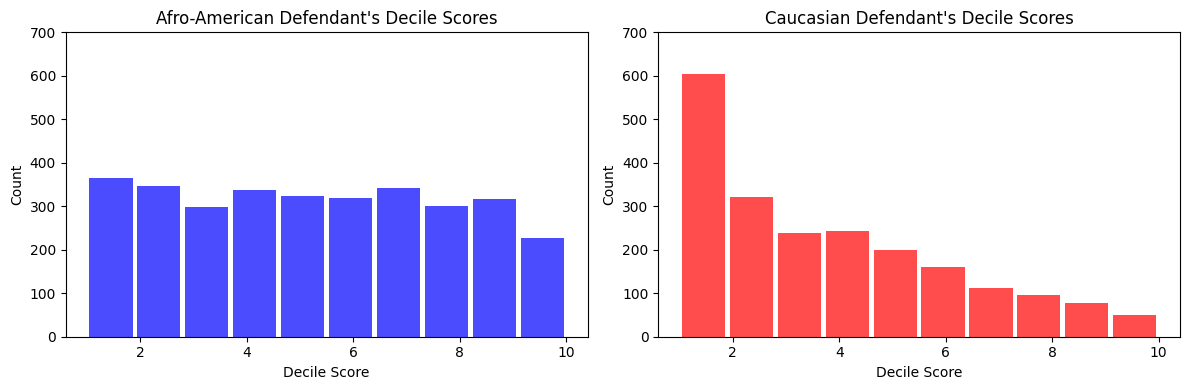

In [ ]:
df_black = dd[dd['race'] == 0]
df_white = dd[dd['race'] == 1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df_black['decile_score'], bins=10, color='b', alpha=0.7,rwidth=0.9)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Defendant's Decile Scores")
ax1.set_ylim(0,700)

ax2.hist(df_white['decile_score'], bins=10, color='r', alpha=0.7,rwidth=0.9)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Defendant's Decile Scores")
ax2.set_ylim(0,700)

plt.tight_layout()

plt.show()

On observe une différence frappante entre les deux distributions qui témoigne d'un biais net contre les Afro-Américains, biais qui sera quantifié plus en détail par la suite grâce à des critères objectifs. En effet, on attribue aux Caucasiens des scores beaucoup plus bas qu'aux Afro-Américains.

####**Tracés parmi les récidivants et non-récidivants**

Traçons maintenant les distributions de scores conditionnellement à l'origine ethnique et à la récidive "réelle" (si la personne a récidivé ou non au bout de 2 ans).

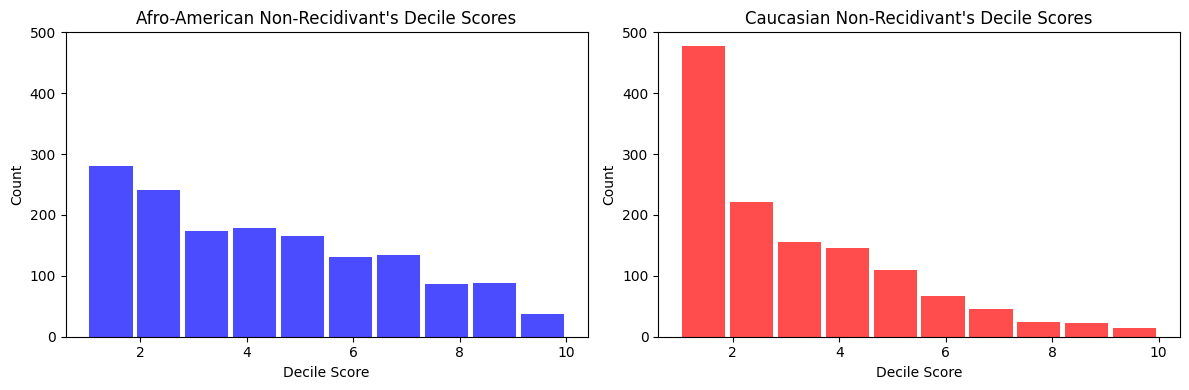

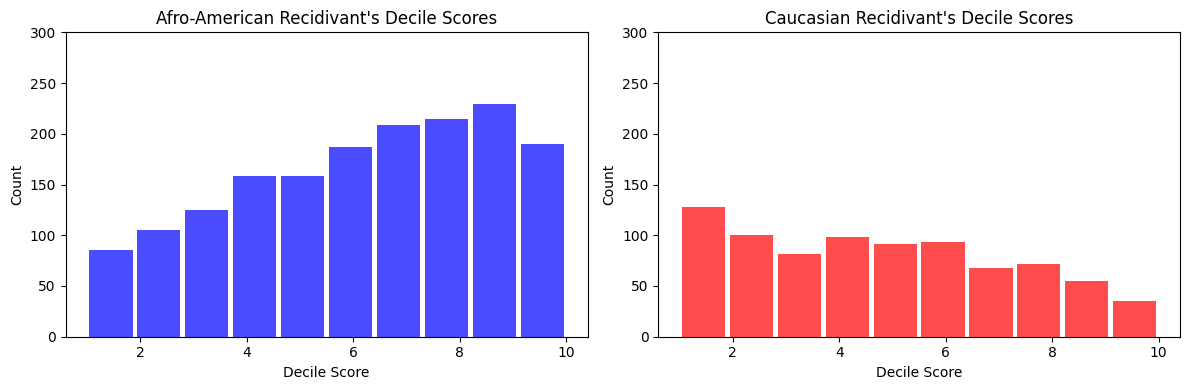

In [ ]:
df_black = dd[dd['race'] == 0][dd['two_year_recid']==0]
df_white = dd[dd['race'] == 1][dd['two_year_recid']==0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df_black['decile_score'], bins=10, color='b', alpha=0.7,rwidth=0.9)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Non-Recidivant's Decile Scores")
ax1.set_ylim(0,500)

ax2.hist(df_white['decile_score'], bins=10, color='r', alpha=0.7,rwidth=0.9)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Non-Recidivant's Decile Scores")
ax2.set_ylim(0, 500) #600*len(df_white)/len(df_black))
plt.tight_layout()

plt.show()
df_black = dd[dd['race'] == 0][dd['two_year_recid']==1]
df_white = dd[dd['race'] == 1][dd['two_year_recid']==1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.hist(df_black['decile_score'], bins=10, color='b', alpha=0.7,rwidth=0.9)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Recidivant's Decile Scores")
ax1.set_ylim(0,300)

ax2.hist(df_white['decile_score'], bins=10, color='r', alpha=0.7,rwidth=0.9)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Recidivant's Decile Scores")
ax2.set_ylim(0,300) #*len(df_white)/len(df_black))

plt.tight_layout()

plt.show()

Encore une fois, les différences de profils demeurent nettes, même en conditionnant par rapport à la récidive réelle. Ainsi, on observe un traitement différencié des Afro-Américains par rapport aux Caucasiens. Nous quantifierons cette différence de traitement par la suite, en utilisant différents critères de fairness notamment les critères de predictive parity et d'equality of odds.

### 1.2. Calcul des critères de fairness

Afin de quantifier la différence de traitement de l'algorithme COMPAS entre les Afro-Américains et les Caucasiens, nous pouvons nous baser sur différents critères de fairness dont nous rappelons les définitions ci-après.

*Définitions*

- **Critère Propublica** : probabilité du score sachant le statut de récidive (encore une fois, on peut regarder deux probabilités, celle sachant que la personne a récidivé, et celle sachant que la personne n'a pas récidivé).
- **Critère Northpointe** : probabilité de récidiver sachant le score (on peut donc regarder deux probabilités différentes, celle sachant que le score est élevé et celle sachant que le score est bas)

Ces deux critères correspondent à deux mesures de fairness qui sont :
- **Equality of odds** : la FPC et la FNC sont égales entre les différents groupes où **FPC** est la false positive classification (parmi ceux qui n'ont pas récidivé, ceux qui ont été classés haut risque) et **FNC** est la false negative classification (parmi ceux qui ont récidivé, ceux qui ont été classés bas risque). Cf. partie 2.4 pour une définition précise.
- **Predictive parity** : la FPP et la FNP sont égales entre les différents groupes où **FPP** est la false positive prediction (parmi ceux classés haut risque, ceux qui n’ont pas récidivé) et **FNP** est la false negative prediction (parmi ceux classés bas risque, ceux qui ont récidivé).

Propublica et Northpointe regardent donc deux critères distincts pour mesurer la fairness de l'algorithme COMPAS.

Un autre critère est très utilisé :
- **Disparate Impact** : ratio des probabilités d'être classé récidivant pour les afro-américains et pour les caucasiens. Autrement dit, la probabilité d'être classé récidivant pour un afro-américain, sur celle pour un caucasien.

#### **Disparate impact**

In [ ]:
accuracy=np.mean(np.abs(np.array(dd['two_year_recid'])-np.array(dd['score_factor'])))
print("Accuracy : %.2f%%" % (100*(1-accuracy)))

Accuracy : 65.82%


In [ ]:
df_black = dd[dd['race'] == 0]
df_white=dd[dd['race']==1]
dispimpact=(np.sum(df_black['two_year_recid'])/len(df_black['two_year_recid']))/(np.sum(df_white['two_year_recid'])/len(df_white['two_year_recid']))
dispimpactalgo=(np.sum(df_black['score_factor'])/len(df_black['score_factor']))/(np.sum(df_white['score_factor'])/len(df_white['score_factor']))

print("Disparate impact réel : {:.2f}".format(dispimpact))
print("Disparate impact algorithmique : {:.2f}".format(dispimpactalgo))

Disparate impact réel : 1.34
Disparate impact algorithmique : 1.74


Dans la réalité (c'est-à-dire en regardant au bout de deux ans qui a récidivé ou non), un Afro-Américain a 1,34 fois plus de chance qu'un Caucasien de récidiver. Mais, dans l'algorithme COMPAS, un Afro-Américain a 1,74 fois plus de chance d'être classé haut risque. Le critère de disparate impact est donc loin d'être respecté.

#### **Critère Northpointe : predictive parity**

In [ ]:
def npcriteria1(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1["score_factor"]==0]
  nb1=Counter(data1recid["two_year_recid"])
  npcriteria1=nb1[1]/len(data1recid)
  data2recid=data2[data2["score_factor"]==0]
  nb2=Counter(data2recid["two_year_recid"])
  npcriteria2=nb2[1]/len(data2recid)
  print("Share of defendants who recidivated among those classified low risk:")
  print("Among Afro-Americans : %.2f%%,  " % (100*npcriteria1), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria1*(1-npcriteria1)/len(data1recid))))
  print("Among Caucasians : %.2f%%,  " % (100*npcriteria2), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria2*(1-npcriteria2)/len(data2recid))))

def npcriteria2(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1["score_factor"]==1]
  nb1=Counter(data1recid["two_year_recid"])
  npcriteria1=nb1[1]/len(data1recid)
  data2recid=data2[data2["score_factor"]==1]
  nb2=Counter(data2recid["two_year_recid"])
  npcriteria2=nb2[1]/len(data2recid)
  print("Share of defendants who recidivated among those classified high risk:")
  print("Among Afro-Americans : %.2f%%,  " % (100*npcriteria1), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria1*(1-npcriteria1)/len(data1recid))))
  print("Among Caucasians : %.2f%%,  " % (100*npcriteria2), "error : %.2f%%" % (100*1.96*np.sqrt(npcriteria2*(1-npcriteria2)/len(data2recid))))

print("\033[1mAll defendants\033[0m")
print("")
npcriteria1(dd[dd['race']==0],dd[dd['race']==1])
print("")
npcriteria2(dd[dd['race']==0],dd[dd['race']==1])

All defendants

Share of defendants who recidivated among those classified low risk:
Among Afro-Americans : 35.14%,   error : 2.55%
Among Caucasians : 29.00%,   error : 2.37%

Share of defendants who recidivated among those classified high risk:
Among Afro-Americans : 64.95%,   error : 2.19%
Among Caucasians : 59.48%,   error : 3.65%


Le critère utilisé par Northpointe est relativement respecté, ce qui est cohérent car il a été utilisé comme réponse dans leur plaidoirie. Toutefois, on peut noter que celui-ci n'est pas parfait.

#### **Critère ProPublica : equality of odds**

In [ ]:
def ppcriteria1(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1[two_year_recid]==0]
  nb1=Counter(data1recid["score_factor"])
  ppcriteria1=nb1[1]/len(data1recid)
  data2recid=data2[data2[two_year_recid]==0]
  nb2=Counter(data2recid["score_factor"])
  ppcriteria2=nb2[1]/len(data2recid)
  print("Share of defendants classified high risk among non-recidivants:")
  print("Among Afro-Americans : %.2f%%,  " % (100*ppcriteria1), "error : %.2f%%" % (100*1.96*np.sqrt(ppcriteria1*(1-ppcriteria1)/len(data1recid))))
  print("Among Caucasians : %.2f%%,  " % (100*ppcriteria2), "error : %.2f%%" % (100*1.96*np.sqrt(ppcriteria2*(1-ppcriteria2)/len(data2recid))))

def ppcriteria2(data1,data2,two_year_recid="two_year_recid",score_factor="score_factor"):
  data1recid=data1[data1[two_year_recid]==1]
  nb1=Counter(data1recid[score_factor])
  ppcriteria1=nb1[1]/len(data1recid)
  data2recid=data2[data2[two_year_recid]==1]
  nb2=Counter(data2recid[score_factor])
  ppcriteria2=nb2[1]/len(data2recid)
  print("Share of defendants classified high risk among recidivants:")
  print("Among Afro-Americans : %.2f%%" % (100*ppcriteria1), "error : %.2f%%" % (100*1.96*np.sqrt(ppcriteria1*(1-ppcriteria1)/len(data1recid))))
  print("Among Caucasians : %.2f%%" % (100*ppcriteria2), "error : %.2f%%" % (100*1.96*np.sqrt(ppcriteria2*(1-ppcriteria2)/len(data2recid))))

print("\033[1mAll defendants\033[0m")
print("")
ppcriteria1(dd[dd['race']==0],dd[dd['race']==1])
print("")
ppcriteria2(dd[dd['race']==0],dd[dd['race']==1])


All defendants

Share of defendants classified high risk among non-recidivants:
Among Afro-Americans : 42.34%,   error : 2.49%
Among Caucasians : 22.01%,   error : 2.27%

Share of defendants classified high risk among recidivants:
Among Afro-Americans : 71.52% error : 2.17%
Among Caucasians : 50.36% error : 3.42%


Au global, le critère d'equality of odds n'est absolument pas respecté avec des différences de l'ordre de 20% non-expliquées par les incertitudes.

En effet, un non-récidivant Afro-Américain a 42% de chance d'être classé à haut risque, contre 22% pour un non-récidivant Caucasien.
Un récidivant Afro-Américain a 72% de chance d'être classé à haut risque, contre 50,4% pour un récidivant Caucasien.

### 1.3. Une question d'âge ?

Une des réponses de Northpointe à notre argumentaire était de dire que les différences observées s'expliquaient par l'effet de d'autres variables, notamment l'âge. L'âge jouant un rôle important dans le score et les Afro-Américains ayant une population plus jeune que les Caucasiens, les Afro-Américains seraient davantage discriminés, non pas à cause de leur origine ethnique, mais à cause de leur âge. Cependant, cet argument n'est pas si clair.

En effet, même si les différences disparaissent lorsqu'on regarde les moins de 25 ans, pour le reste de la population (> 25 ans), il reste des différences, différences qui ne peuvent plus s'expliquer par l'âge. Nous pouvons vérifier cela en calculant l'equality of odds et la predictive parity pour les jeunes et pour le reste de la population, et en traçant la distribution des scores.

##### **Predictive parity**

In [ ]:
print("\033[1mYounger (< 25 years)\033[0m")
print("")
npcriteria1(dd[dd['agecat2']==0][dd['race']==0],dd[dd['agecat2']==0][dd['race']==1])
print("")
npcriteria2(dd[dd['agecat2']==0][dd['race']==0],dd[dd['agecat2']==0][dd['race']==1])
print("")
print("")
print("\033[1mOlder (> 25 years)\033[0m")
print("")
npcriteria1(dd[dd['agecat2']==1][dd['race']==0],dd[dd['agecat2']==1][dd['race']==1])
print("")
npcriteria2(dd[dd['agecat2']==1][dd['race']==0],dd[dd['agecat2']==1][dd['race']==1])

Younger (< 25 years)

Share of defendants who recidivated among those classified low risk:
Among Afro-Americans : 48.40%,   error : 6.19%
Among Caucasians : 33.33%,   error : 7.87%

Share of defendants who recidivated among those classified high risk:
Among Afro-Americans : 66.19%,   error : 3.92%
Among Caucasians : 58.85%,   error : 6.67%


Older (> 25 years)

Share of defendants who recidivated among those classified low risk:
Among Afro-Americans : 32.12%,   error : 2.76%
Among Caucasians : 28.53%,   error : 2.48%

Share of defendants who recidivated among those classified high risk:
Among Afro-Americans : 64.41%,   error : 2.63%
Among Caucasians : 59.75%,   error : 4.36%


##### **Equality of odds**

In [ ]:
print("\033[1mYounger (< 25 years)\033[0m")
print("")
ppcriteria1(dd[dd['agecat2']==0][dd['race']==0],dd[dd['agecat2']==0][dd['race']==1])
print("")
ppcriteria2(dd[dd['agecat2']==0][dd['race']==0],dd[dd['agecat2']==0][dd['race']==1])
print("")
print("")
print("\033[1mOlder (> 25 years)\033[0m")
print("")
ppcriteria1(dd[dd['agecat2']==1][dd['race']==0],dd[dd['agecat2']==1][dd['race']==1])
print("")
ppcriteria2(dd[dd['agecat2']==1][dd['race']==0],dd[dd['agecat2']==1][dd['race']==1])

Younger (< 25 years)

Share of defendants classified high risk among non-recidivants:
Among Afro-Americans : 59.43%,   error : 5.40%
Among Caucasians : 48.31%,   error : 7.34%

Share of defendants classified high risk among recidivants:
Among Afro-Americans : 75.36% error : 3.81%
Among Caucasians : 72.78% error : 6.71%


Older (> 25 years)

Share of defendants classified high risk among non-recidivants:
Among Afro-Americans : 37.79%,   error : 2.75%
Among Caucasians : 17.77%,   error : 2.26%

Share of defendants classified high risk among recidivants:
Among Afro-Americans : 69.91% error : 2.63%
Among Caucasians : 44.56% error : 3.81%


Ainsi, lorsqu'on conditionne par l'âge, les jeunes vérifient effectivement le critère de Propublica. Mais, on retrouve des biais pour les plus de 25 ans, ce qui montre que ces biais ne peuvent être expliqués par une prédominance de jeunes parmi les Afro-Américains.

##### **Distribution des scores**

Nous pouvons visualiser ça en traçant la distribution des scores pour les plus de 25 ans. Des différences flagrantes demeurent.

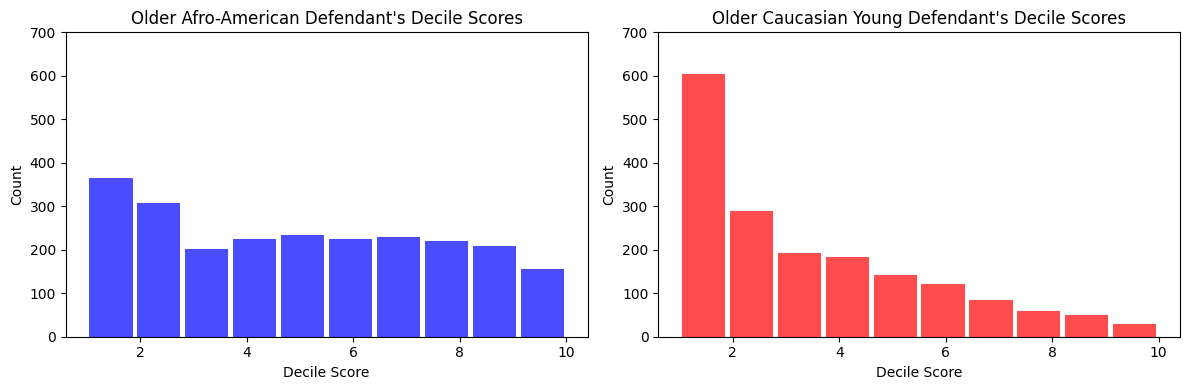

In [ ]:
df_black = dd[dd['race']==0]
df_black_old = df_black[df_black['agecat2']==1]
df_white = dd[dd['race']==1]
df_white_old = df_white[df_white['agecat2']==1]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot for Black defendants
ax1.hist(df_black_old['decile_score'], bins=10, color='b', alpha=0.7,rwidth=0.9)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Older Afro-American Defendant's Decile Scores")
ax1.set_ylim(0,700)

# Plot for White defendants
ax2.hist(df_white_old['decile_score'], bins=10, color='r', alpha=0.7,rwidth=0.9)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Older Caucasian Young Defendant's Decile Scores")
ax2.set_ylim(0,700)

plt.tight_layout()
plt.show()

## 2. Réalisation d'un algorithme satisfaisant les deux critères

Par ailleurs, la réponse de Northpointe reposait sur le fait qu'il n'est pas possible de satisfaire simultanément les critères de predictive parity et d'equality of odds. S'il est vrai qu'il n'est pas possible de les vérifier parfaitement, il est possible de les optimiser et de faire mieux que COMPAS ce que nous montrons dans cette partie.

### 2.1. Reproduction de COMPAS par l'implémentation de XGBoost

Dans cette partie, nous implémentons un modèle pour prédire le score avec XGBoost, nous essayerons de l'optimiser dans la partie suivante.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
def split_scale_pipe(X, y, Z, stratify, test_size=0.5, random_state=11):
    (X_train, X_test, y_train, y_test,
     Z_train, Z_test) = train_test_split(X, y, Z, test_size=test_size,
                                         stratify=y, random_state=random_state)

    # standardize the data
    scaler = StandardScaler().fit(X_train)
    scale_df = lambda df, scaler: pd.DataFrame(scaler.transform(df),
                                               columns=df.columns, index=df.index)
    X_train = X_train.pipe(scale_df, scaler)
    X_test = X_test.pipe(scale_df, scaler)

    return (X_train, X_test, y_train, y_test, Z_train, Z_test)

In [ ]:
import statsmodels.api as sm
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

def xgboost(dataset,thre,max_depth,sensitive_var='race',test_size=0.1):
  X = dataset.drop(columns = ['score_factor','two_year_recid', 'decile_score','age_cat'])
  Z = dataset.race
  y = dataset.two_year_recid
  n_features = X.shape[1]

  NPCRITERIA1=[]
  NPCRITERIA2=[]
  PPCRITERIA1=[]
  PPCRITERIA2=[]
  RES=[]
  SCORES=[]
  RECID=[]
  for i in range (0,50):
    (X_train, X_test, y_train, y_test, Z_train, Z_test) = split_scale_pipe(X, y, Z, stratify=y,random_state=i,test_size=test_size)
    X_train=pd.concat([X_train,dataset[dataset[sensitive_var]==1].drop(columns = ['score_factor','two_year_recid', 'decile_score','age_cat'])])
    X_train[sensitive_var]=[0]*len(X_train)
    X_test['two_year_recid']=y_test
    X_test=X_test.drop_duplicates()
    y_train=pd.concat([y_train,dataset[dataset[sensitive_var]==1].two_year_recid])
    dtrain_reg = xgb.DMatrix(X_train, y_train, enable_categorical=True)
    dtest_reg = xgb.DMatrix(X_test.drop(columns=['two_year_recid']), X_test['two_year_recid'], enable_categorical=True)
    params = {"objective": "reg:squarederror", "tree_method": "approx","max_depth":max_depth,"subsample":1,"eta":0.3}
    n = 10
    model = xgb.train(params=params,dtrain=dtrain_reg,num_boost_round=n)
    preds = model.predict(dtest_reg)
    threshold=thre
    y_pred_bin = [1 if y >= threshold else 0 for y in preds]
    dif=abs(np.array(y_pred_bin)-np.array(X_test['two_year_recid']))
    RES.append(np.mean(dif))
    X_test['score_factor']=y_pred_bin
    NPCRITERIA1.append(npcriteria1uni(X_test)[0])
    NPCRITERIA2.append(npcriteria2uni(X_test)[0])
    PPCRITERIA1.append(ppcriteria1uni(X_test)[0])
    PPCRITERIA2.append(ppcriteria2uni(X_test)[0])
    preds2=preds
    y_score=[int(10*x)+1 for x in preds2]
    SCORES+=y_score
    RECID+=list(X_test['two_year_recid'])
  return(np.mean(RES),np.mean(NPCRITERIA1),np.mean(NPCRITERIA2),np.mean(PPCRITERIA1),np.mean(PPCRITERIA2),SCORES,RECID)

Nous faisons un premier test pour voir si notre algorithme fonctionne.

African-Americans :
Accuracy : 32.48%, NP criteria : 34.49%/69.30%, PP criteria : 35.50%/70.17%
Accuracy : 1.26%, NP criteria : 2.39%/2.21%, PP criteria :2.55%/2.09%
Caucasians :
Accuracy : 33.76%, NP criteria : 32.42%/62.71%, PP criteria : 16.60%/40.92%
Accuracy : 1.27%, NP criteria : 2.56%/3.30%, PP criteria :1.94%/3.65%


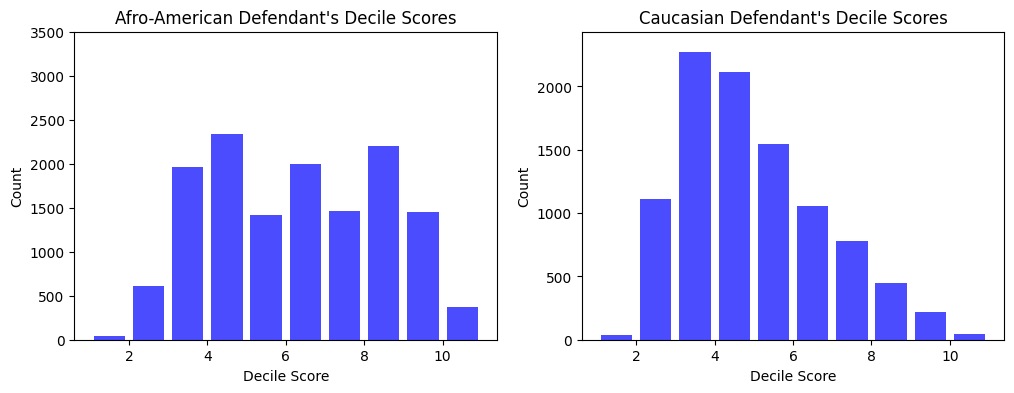

In [ ]:
res=xgboost(dd[dd['race']==0],max_depth=5,thre=0.5)
errac=1.96*np.sqrt(res[0]*(1-res[0])/len(dd))
nbblackrecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res[2]*(1-res[2])/nbblackrecid)
nbblacknorecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res[1]*(1-res[1])/nbblacknorecid)
nbblackrisk=len(dd[(dd['race']==0)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res[4]*(1-res[4])/nbblackrisk)
nbblacknorisk=len(dd[(dd['race']==0)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res[3]*(1-res[3])/nbblacknorisk)
print("African-Americans :")
print("Accuracy : "+str(100*res[0])[0:5]+"%, NP criteria : "+str(100*res[1])[0:5]+"%/"+str(100*res[2])[0:5]+"%, PP criteria : "+str(100*res[3])[0:5]+"%/"+str(100*res[4])[0:5]+"%")
print("Accuracy : "+str(100*errac)[0:4]+"%, NP criteria : "+str(100*errb1)[0:4]+"%/"+str(100*errb2)[0:4]+"%, PP criteria :"+str(100*errb3)[0:4]+"%/"+str(100*errb4)[0:4]+"%")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(res[5]+[1], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Defendant's Decile Scores")
ax1.set_ylim(0,3500)
res2=xgboost(dd[dd['race']==1],max_depth=5,thre=0.5)
errac=1.96*np.sqrt(res2[0]*(1-res2[0])/len(dd))
nbwhiterecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res2[2]*(1-res2[2])/nbwhiterecid)
nbwhitenorecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res2[1]*(1-res2[1])/nbwhitenorecid)
nbwhiterisk=len(dd[(dd['race']==1)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res2[4]*(1-res2[4])/nbwhiterisk)
nbwhitenorisk=len(dd[(dd['race']==1)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res2[3]*(1-res2[3])/nbwhitenorisk)
print("Caucasians :")
print("Accuracy : "+str(100*res2[0])[0:5]+"%, NP criteria : "+str(100*res2[1])[0:5]+"%/"+str(100*res2[2])[0:5]+"%, PP criteria : "+str(100*res2[3])[0:5]+"%/"+str(100*res2[4])[0:5]+"%")
print("Accuracy : "+str(100*errac)[0:4]+"%, NP criteria : "+str(100*errb1)[0:4]+"%/"+str(100*errb2)[0:4]+"%, PP criteria :"+str(100*errb3)[0:4]+"%/"+str(100*errb4)[0:4]+"%")
ax2.hist(res2[5]+[10,1,2], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Defendant's Decile Scores")
ax2.set_ylim(0,3500*len(res2[5])/len(res[5]))
plt.show()

Cette première version, basique, nous permet de respecter le critère de Northpointe directement. Mais le critère de ProPublica est largement non-respecté. On obtient donc des performances similaires à celles de l'algorithme de NorthPointe, en appliquant simplement un modèle de machine learning classique (XGBoost).

### 2.2. Première optimisation

Essayons maintenant d'optimiser cet algorithme pour satisfaire les deux critères considérés (classifieurs séparés et seuils différents en fonction de l'origine ethnique).

African-Americans :
Accuracy : 33.53%, NP criteria : 38.42%/73.06%, PP criteria :24.79%/58.82%
Accuracy : 1.27%, NP criteria : 2.450%/2.133%, PP criteria :2.307%/2.255%
Caucasians :
Accuracy : 34.83%, NP criteria : 29.71%/57.23%, PP criteria : 27.88%/54.91%
Accuracy : 1.28%, NP criteria : 2.50%/3.38%, PP criteria :2.34%/3.69%


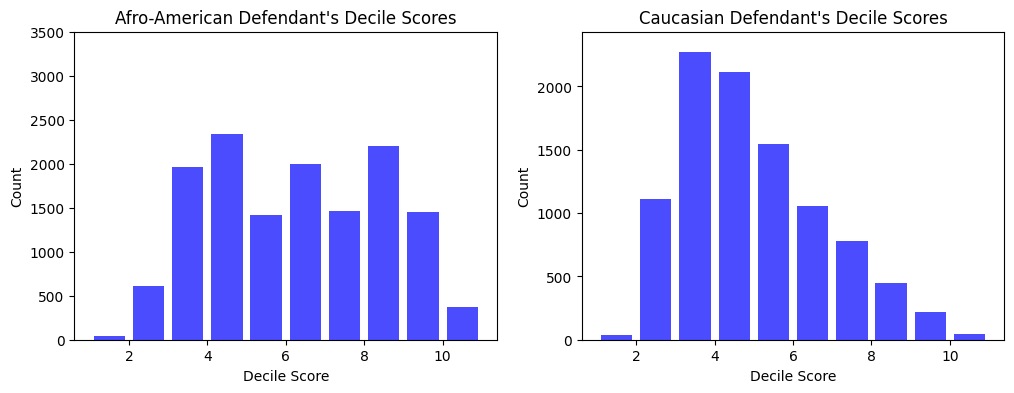

In [ ]:
res=xgboost(dd[dd['race']==0],max_depth=5,thre=0.58)
errac=1.96*np.sqrt(res[0]*(1-res[0])/len(dd))
nbblackrecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res[2]*(1-res[2])/nbblackrecid)
nbblacknorecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res[1]*(1-res[1])/nbblacknorecid)
nbblackrisk=len(dd[(dd['race']==0)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res[4]*(1-res[4])/nbblackrisk)
nbblacknorisk=len(dd[(dd['race']==0)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res[3]*(1-res[3])/nbblacknorisk)
print("African-Americans :")
print("Accuracy : "+str(100*res[0])[0:5]+"%, NP criteria : "+str(100*res[1])[0:5]+"%/"+str(100*res[2])[0:5]+"%, PP criteria :"+str(100*res[3])[0:5]+"%/"+str(100*res[4])[0:5]+"%")
print("Accuracy : "+str(100*errac)[0:4]+"%, NP criteria : "+str(100*errb1)[0:5]+"%/"+str(100*errb2)[0:5]+"%, PP criteria :"+str(100*errb3)[0:5]+"%/"+str(100*errb4)[0:5]+"%")
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(res[5]+[1], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Defendant's Decile Scores")
ax1.set_ylim(0,3500)
res2=xgboost(dd[dd['race']==1],max_depth=5,thre=0.42)
errac=1.96*np.sqrt(res2[0]*(1-res2[0])/len(dd))
nbwhiterecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res2[2]*(1-res2[2])/nbwhiterecid)
nbwhitenorecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res2[1]*(1-res2[1])/nbwhitenorecid)
nbwhiterisk=len(dd[(dd['race']==1)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res2[4]*(1-res2[4])/nbwhiterisk)
nbwhitenorisk=len(dd[(dd['race']==1)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res2[3]*(1-res2[3])/nbwhitenorisk)
print("Caucasians :")
print("Accuracy : "+str(100*res2[0])[0:5]+"%, NP criteria : "+str(100*res2[1])[0:5]+"%/"+str(100*res2[2])[0:5]+"%, PP criteria : "+str(100*res2[3])[0:5]+"%/"+str(100*res2[4])[0:5]+"%")
print("Accuracy : "+str(100*errac)[0:4]+"%, NP criteria : "+str(100*errb1)[0:4]+"%/"+str(100*errb2)[0:4]+"%, PP criteria :"+str(100*errb3)[0:4]+"%/"+str(100*errb4)[0:4]+"%")
ax2.hist(res2[5]+[10,1,2], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Defendant's Decile Scores")
ax2.set_ylim(0,3500*len(res2[5])/len(res[5]))
plt.show()

Cette deuxième version repose sur le même algorithme que précédemment mais modifie les seuils de classification binaire. Par un tradeoff, on obtient que l'equality of odds est plus proche d'être respectée que dans COMPAS

Au niveau de la predictive parity, les critères ne sont pas encore respectés, mais les différences en pourcentage sont moins importantes que celles enregistrées sur COMPAS.

### 2.3. Deuxième optimisation

Nous faisons un troisième test de XGBoost, avec des classifieurs séparés et un rééquilibrage des poids entre Afro-Américains et Caucasiens.

In [ ]:
## On duplique des échantillons afin d'avoir un même ratio récidivants/non-récidivants parmi les Whites et les Blacks, conditionnellement à la catégorie d'âge

condition = (dd['agecat2'] == 1) & (dd['two_year_recid'] == 1) & (dd['race']==1)
rows_to_duplicate = dd[condition].head(520)
ddc = pd.concat([dd, rows_to_duplicate], ignore_index=True)
condition = (ddc['agecat2'] == 0) & (ddc['two_year_recid'] == 0) & (ddc['race']==0)
rows_to_duplicate = ddc[condition].head(150)
ddb = pd.concat([ddc, rows_to_duplicate], ignore_index=True)

Les choix de 520 et 150 ont été réalisés de façon à obtenir un ratio récidivants/non-récidivants égal parmi les Caucasiens et les Afro-Américains, au sens général mais aussi conditionnellement à la catégorie d'âge. En effet, les régressions logistiques ont prouvé l'importance prépondérante de l'âge dans la détermination du risque.

Cette manipulation concerne uniquement l'échantillon de train et non de test, car la fonction xgboost supprime les doublons dans l'ensemble de test. Ainsi les critères ne sont pas faussés par cette manipulation.


Afro-Americans :
Accuracy : 67.15%, NP criteria : 35.02%/69.41%, PP criteria :31.99%/66.38%
Erracc  : 1.26%, NP  errors : 2.40%/2.21%, PP  errors :2.49%/2.16%
Caucasians :
Accuracy : 63.63%, NP criteria : 37.98%/65.45%, PP criteria : 35.10%/62.44%
Erracc  : 1.29%, NP  errors : 2.65%/3.25%, PP  errors :2.49%/3.59%


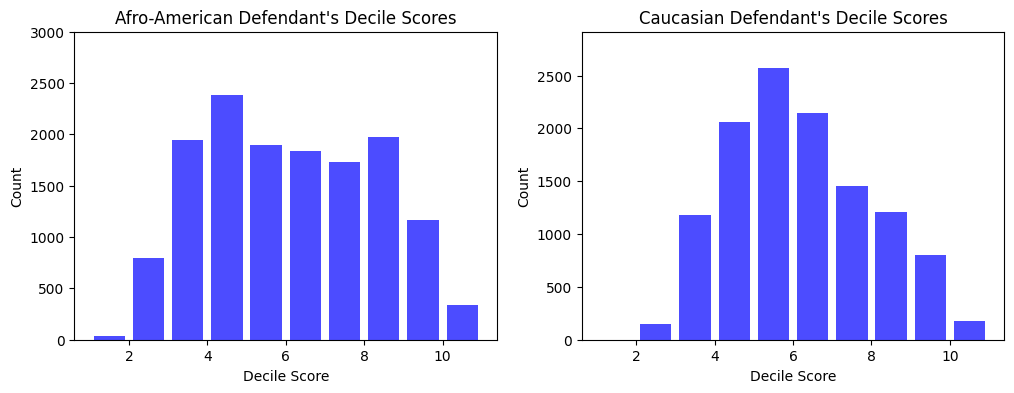

In [ ]:
#entraînement du modèle XGBoost pour les Blacks
res=xgboost(ddb[ddb['race']==0],max_depth=5,thre=0.5)
errac=1.96*np.sqrt(res[0]*(1-res[0])/len(dd))
nbblackrecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res[2]*(1-res[2])/nbblackrecid)
nbblacknorecid=len(dd[(dd['race']==0)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res[1]*(1-res[1])/nbblacknorecid)
nbblackrisk=len(dd[(dd['race']==0)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res[4]*(1-res[4])/nbblackrisk)
nbblacknorisk=len(dd[(dd['race']==0)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res[3]*(1-res[3])/nbblacknorisk)

#Critères de fairness
print("Afro-Americans :")
print("Accuracy : "+str(100*(1-res[0]))[0:5]+"%, NP criteria : "+str(100*res[1])[0:5]+"%/"+str(100*res[2])[0:5]+"%, PP criteria :"+str(100*res[3])[0:5]+"%/"+str(100*res[4])[0:5]+"%")
print("Erracc  : "+str(100*errac)[0:4]+"%, NP  errors : "+str(100*errb1)[0:4]+"%/"+str(100*errb2)[0:4]+"%, PP  errors :"+str(100*errb3)[0:4]+"%/"+str(100*errb4)[0:4]+"%")

#Tracé des distributions de scores
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(res[5]+[1], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Defendant's Decile Scores")
ax1.set_ylim(0,3000)

#entraînement du modèle XGBoost pour les Whites
res2=xgboost(ddb[ddb['race']==1],max_depth=5,thre=0.5)
errac=1.96*np.sqrt(res2[0]*(1-res2[0])/len(dd))
nbwhiterecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==1)])
errb2=1.96*np.sqrt(res2[2]*(1-res2[2])/nbwhiterecid)
nbwhitenorecid=len(dd[(dd['race']==1)&(dd['two_year_recid']==0)])
errb1=1.96*np.sqrt(res2[1]*(1-res2[1])/nbwhitenorecid)
nbwhiterisk=len(dd[(dd['race']==1)&(dd['score_factor']==1)])
errb4=1.96*np.sqrt(res2[4]*(1-res2[4])/nbwhiterisk)
nbwhitenorisk=len(dd[(dd['race']==1)&(dd['score_factor']==0)])
errb3=1.96*np.sqrt(res2[3]*(1-res2[3])/nbwhitenorisk)
#Critères de fairness
print("Caucasians :")
print("Accuracy : "+str(100*(1-res2[0]))[0:5]+"%, NP criteria : "+str(100*res2[1])[0:5]+"%/"+str(100*res2[2])[0:5]+"%, PP criteria : "+str(100*res2[3])[0:5]+"%/"+str(100*res2[4])[0:5]+"%")
print("Erracc  : "+str(100*errac)[0:4]+"%, NP  errors : "+str(100*errb1)[0:4]+"%/"+str(100*errb2)[0:4]+"%, PP  errors :"+str(100*errb3)[0:4]+"%/"+str(100*errb4)[0:4]+"%")

#Tracé des distributions de scores
ax2.hist(res2[5]+[10,1,2], bins=10, color='b', alpha=0.7,rwidth=0.8)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Defendant's Decile Scores")
ax2.set_ylim(0,3500*len(res2[5])/len(res[5]))
plt.show()

Avec cette méthode, les deux critères sont respectés : celui de ProPublica et celui de Northpointe (intervalles de confiance se chevauchant), sans biais net envers une communauté. L'accuracy moyenne est de plus de 65%, ce qui constitue une performance similaire à celle de COMPAS.


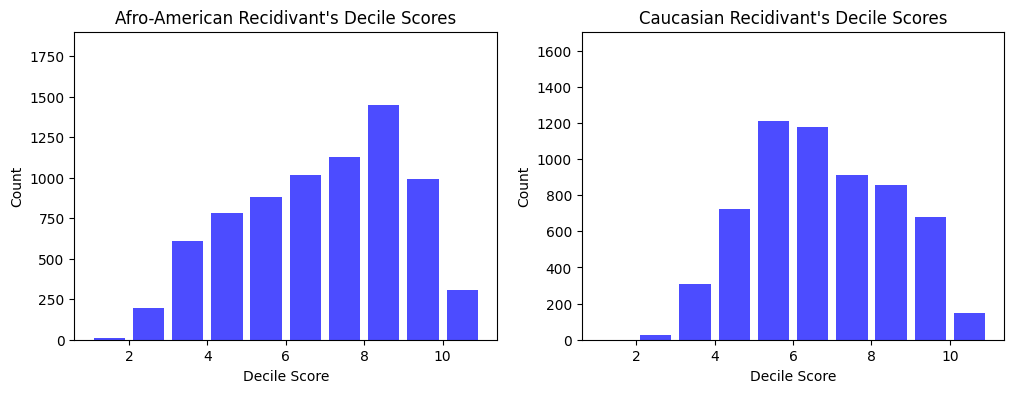

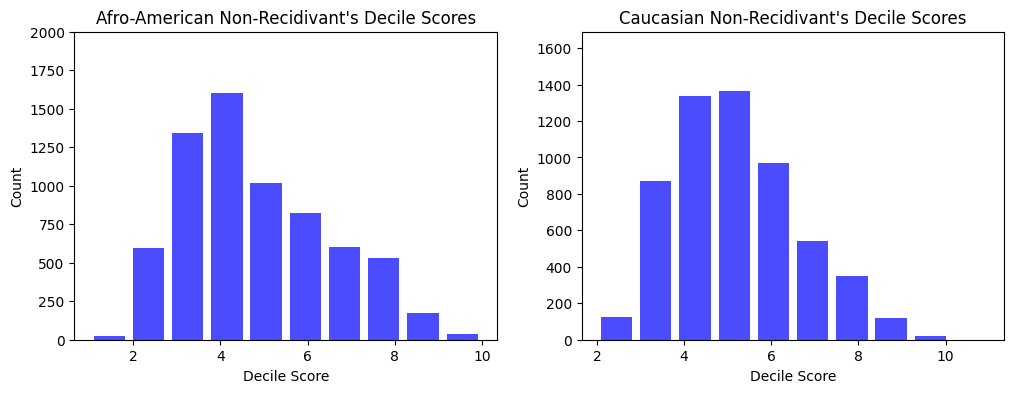

In [ ]:
hist_norecid_b=[res[5][i] for i in np.where(np.array(res[6]) == 0)[0]]
hist_recid_b=[res[5][i] for i in np.where(np.array(res[6]) == 1)[0]]
hist_norecid_w=[res2[5][i] for i in np.where(np.array(res2[6]) == 0)[0]]
hist_recid_w=[res2[5][i] for i in np.where(np.array(res2[6]) == 1)[0]]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(hist_recid_b, bins=10, color='b', alpha=0.7,rwidth=0.8)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Recidivant's Decile Scores")
ax1.set_ylim(0,1900)

ax2.hist(hist_recid_w, bins=10, color='b', alpha=0.7,rwidth=0.8)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Recidivant's Decile Scores")
ax2.set_ylim(0,1900*len(hist_recid_w)/len(hist_norecid_b))
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.hist(hist_norecid_b, bins=10, color='b', alpha=0.7,rwidth=0.8)
ax1.set_xlabel('Decile Score')
ax1.set_ylabel('Count')
ax1.set_title("Afro-American Non-Recidivant's Decile Scores")
ax1.set_ylim(0,2000)

ax2.hist(hist_norecid_w, bins=10, color='b', alpha=0.7,rwidth=0.8)
ax2.set_xlabel('Decile Score')
ax2.set_ylabel('Count')
ax2.set_title("Caucasian Non-Recidivant's Decile Scores")
ax2.set_ylim(0,2000*len(hist_norecid_w)/len(hist_norecid_b))
plt.show()

Les distributions conditionnelles sont bien plus similaires et ne présentent pas de biais évidents envers une communauté plutôt qu'une autre. On notera que la différence parmi les récidivants, avec plus de hauts scores parmi les Afro-Américains, est liée à un taux crimes/délits plus important.

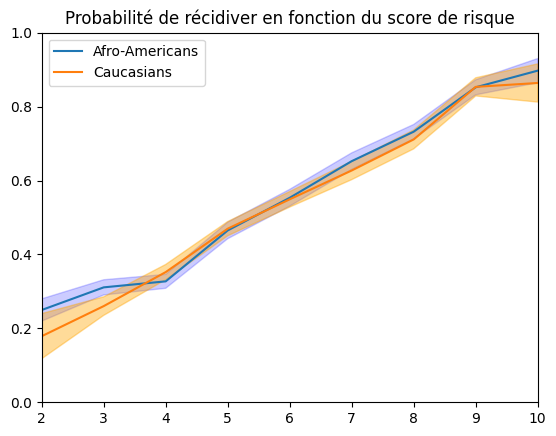

In [ ]:
VAL=[]
INCER=[]
for i in range (1,11):
  indices=np.where(np.array(res[5])==i)[0]
  recid=[res[6][i] for i in indices]
  val=np.mean(recid)
  incer=1.96*np.sqrt(val*(1-val)/len(recid))
  VAL.append(val)
  INCER.append(incer)
plt.plot(np.arange(1,11,1),VAL,label="Afro-Americans")
plt.fill_between(np.arange(1,11,1),np.array(VAL)-np.array(INCER),np.array(VAL)+np.array(INCER),alpha=0.2,color="blue")
VAL=[]
INCER=[]
for i in range (1,11):
  indices=np.where(np.array(res2[5])==i)[0]
  recid=[res2[6][i] for i in indices]
  val=np.mean(recid)
  incer=1.96*np.sqrt(val*(1-val)/len(recid))
  VAL.append(val)
  INCER.append(incer)
plt.plot(np.arange(1,11,1),VAL,label="Caucasians")
plt.fill_between(np.arange(1,11,1),np.array(VAL)-np.array(INCER),np.array(VAL)+np.array(INCER),alpha=0.4,color="orange")
plt.legend()
plt.xlim(2,10)
plt.ylim(0,1)
plt.title(label="Probabilité de récidiver en fonction du score de risque")
plt.show()

Les probabilité de récidiver en fonction du score sont très proches et les intervalles de confiance se chevauchent, ce qui permet de valider le critère de Northpointe à une échelle plus fine.

In [ ]:
df_black = dd[dd['race'] == 0]
df_white=dd[dd['race']==1]
dispimpact=(np.sum(df_black['two_year_recid'])/len(df_black['two_year_recid']))/(np.sum(df_white['two_year_recid'])/len(df_white['two_year_recid']))
dispimpactalgo=(np.sum(df_black['score_factor'])/len(df_black['score_factor']))/(np.sum(df_white['score_factor'])/len(df_white['score_factor']))

print("Disparate impact réel : {:.2f}".format(dispimpact))
print("Disparate impact algorithmique : {:.2f}".format(dispimpactalgo))

score_w=[a>=5 for a in res[5]]
score_b=[a>=5 for a in res2[5]]
dispimpactalgo=np.mean(score_b)/np.mean(score_w)

print("Disparate impact nouvel algorithme : {:.2f}".format(dispimpactalgo))


Disparate impact réel : 1.34
Disparate impact algorithmique : 1.74
Disparate impact nouvel algorithme : 1.12


On constate que le disparate impact de notre nouvel algorithme est plus proche de la réalité que le disparate impact de COMPAS.

### 2.4. Conclusion


La réalisation d'un algorithme avec XGBoost, basé sur un rééquilibrage des poids, prouve que la satisfaction combinée des critères de ProPublica et NorthPointe est possible. Il est important de noter que notre algorithme démontre une accuracy similaire, et performe également mieux sur le critère du disparate impact que COMPAS

Les critères de disparate impact, predictive parity, et equality of odds sont 3 critères qui ne peuvent pas être satisfaits exactement en même temps. (Voir "Fairness Metrics : A comparative analysis", P. Garg et al.). Cependant, il est du devoir de Northpointe de les satisfaire au mieux. Notre algorithme obtient un meilleur score pour chacun de ces 3 critères avec des outils relativement élémentaires disponibles à l'époque du développement de COMPAS. Cela montre donc que le biais était largement évitable.

La méthode de rééquilibrage, réalisée de façon spécifique dans notre cas, peut être étendue à d'autres cas de figure, ce qui dépasse la visée de cette étude. Des méthodes de Deep Learning, basée sur l'optimisation combinée d'une loss classique et d'une "Fair Loss", pourraient également être exploitées.


## 3. Questionnement éthique et juridique

Terminons cette plaidoirie par une réflexion éthique sur l'utilisation de ce genre d'algorithmes dans le système judiciaire.

L'utilisation d'algorithmes tels que COMPAS dans le système judiciaire soulève des préoccupations fondamentales. Tout d'abord, et c'est ce que nous avons montré précédemment, ce type d'algorithmes peut amplifier des inégalités déjà présentes. Les données historiques utilisées pour entraîner ces algorithmes peuvent refléter des discriminations systémiques existantes, introduisant ainsi des préjugés dans les prédictions futures. Cela perpétue et amplifie les inégalités présentes dans le système judiciaire, ce qui est le cas avec COMPAS et les Afro-Américains.

Par ailleurs, l'opacité qui entoure les mécanismes internes de ces algorithmes, détenus par des entreprises privées, est particulièrement problématique car elle crée un voile de mystère autour de décisions qui affectent directement la vie des individus. Cette absence de transparence compromet le principe fondamental de la justice selon lequel les personnes devraient comprendre les motifs et les critères qui influent sur les décisions qui les concernent. Ainsi, l'utilisation d'algorithmes comme COMPAS peut compromettre le droit à un procès équitable. Les individus sont confrontés à des décisions algorithmiques souvent complexes sans avoir une compréhension adéquate de la logique derrière ces choix. Cela peut entraver leur capacité à contester efficacement les résultats et à faire valoir leurs droits devant la justice.

En résumé, l'utilisation de tels algorithmes dans le système judiciaire présente des risques sérieux en termes de transparence, de perpétuation des inégalités et de respect des droits individuels. Au-delà de considérations générales, dans le contexte spécifique de COMPAS, comment peut-on défendre l'utilisation d'un algorithme présentant une faible précision et des biais évidents contre une minorité ? Il semble clair que COMPAS n'a pas sa place dans le système judiciaire


